In [ ]:
!pip install scanpy

In [ ]:
!pip install anndata

In [ ]:
!pip3 install igraph

In [ ]:
!pip install celltypist

In [ ]:
!pip install decoupler

In [ ]:
!pip install fa2-modified

In [ ]:
!pip install louvain

In [ ]:
!pip install scvelo

In [ ]:
#Import core single cell datasets

import scanpy as sc
import anndata as ad
import numpy as np
#import scvelo as scv

Preprocessing

Unzipping and Loading Datasets

In [ ]:
!wget "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE166nnn/GSE166766/suppl/GSE166766_RAW.tar"

--2025-12-13 11:23:44--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE166nnn/GSE166766/suppl/GSE166766_RAW.tar
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.11, 130.14.250.12, 130.14.250.13, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 838123520 (799M) [application/x-tar]
Saving to: ‘GSE166766_RAW.tar’

GSE166766_RAW.tar   100%[===================>] 799.30M  35.9MB/s    in 33s     

2025-12-13 11:24:18 (24.0 MB/s) - ‘GSE166766_RAW.tar’ saved [838123520/838123520]



In [ ]:
!mkdir -p extracted_raw
!tar -xvf GSE166766_RAW.tar -C extracted_raw

GSM5082289_mock_barcodes.tsv.gz
GSM5082289_mock_features.tsv.gz
GSM5082289_mock_matrix.mtx.gz
GSM5082290_1dpi_barcodes.tsv.gz
GSM5082290_1dpi_features.tsv.gz
GSM5082290_1dpi_matrix.mtx.gz
GSM5082291_2dpi_barcodes.tsv.gz
GSM5082291_2dpi_features.tsv.gz
GSM5082291_2dpi_matrix.mtx.gz
GSM5082292_3dpi_barcodes.tsv.gz
GSM5082292_3dpi_features.tsv.gz
GSM5082292_3dpi_matrix.mtx.gz


In [ ]:
!pwd

/content


In [ ]:
#Import and load  datasets
adata_mock = sc.read_10x_mtx('/content/extracted_raw/', prefix='GSM5082289_mock_')

In [ ]:
print(adata_mock)

AnnData object with n_obs × n_vars = 22609 × 33539
    var: 'gene_ids', 'feature_types'


In [ ]:
adata_list = [adata_mock]
adata = ad.concat(adata_list)

In [ ]:
adata

AnnData object with n_obs × n_vars = 22609 × 33539

In [ ]:
adata_mock.var.head()

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression


Quality Control (QC)


Compute quality control metrics

In [ ]:
# Basic QC before filtering

## -- Identification of low-quality or dying cells

#mock dataset
adata_mock.var["MT"] = adata_mock.var_names.str.startswith("MT-")
adata_mock.var["RIBO"] = adata_mock.var_names.str.startswith(("RPS","RPL"))
adata_mock.var["HB"] = adata_mock.var_names.str.contains(("^HB[^(P)]"))
sc.pp.calculate_qc_metrics(
    adata_mock,qc_vars=["MT", 'RIBO', 'HB'], inplace=True, log1p=True
)


Visualize before filtering

In [ ]:
# Plot style setup for visual consistency
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (5,4)  # Adjust figure size
plt.rcParams["axes.grid"] = True  # Add grid to plots
plt.rcParams["axes.edgecolor"] = "black" # Set plot border color
plt.rcParams["axes.linewidth"] = 1.5 # Set plot border width
plt.rcParams["axes.facecolor"] = "white" # Set background color
plt.rcParams["axes.labelcolor"] = "black" # Set label color
plt.rcParams["xtick.color"] = "black" # Set x-axis tick color
plt.rcParams["ytick.color"] = "black" # Set y-axis tick color
plt.rcParams["text.color"] = "black" # Set text color
%matplotlib inline

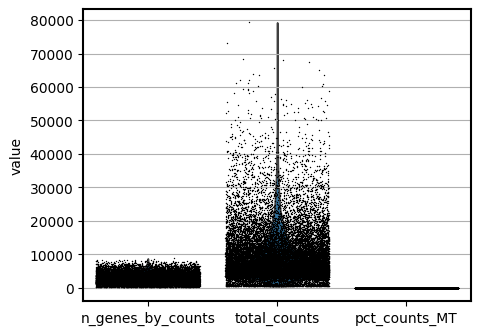

In [ ]:
#Violin plots

#mock dataset
sc.pl.violin(
    adata_mock,
    ["n_genes_by_counts", 'total_counts', 'pct_counts_MT'],
    jitter=0.4,
    multi_panel=False,
)

In [ ]:
def plot_qc_metrics(adata):
    sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                 jitter=0.4, multi_panel=True)
    plt.show()

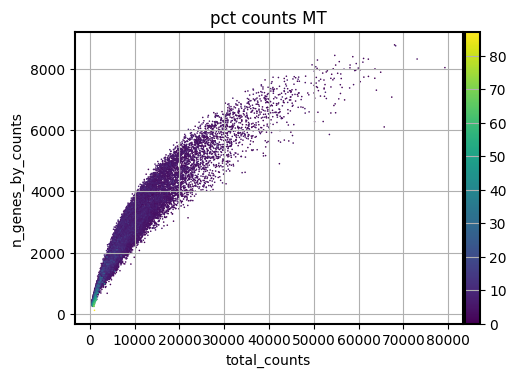

In [ ]:
# Scatter plot of MT genes

#mock
sc.pl.scatter(adata_mock, "total_counts", "n_genes_by_counts", color="pct_counts_MT")

In [ ]:
# filter for percent mito
# We filter out cells with >10% mitochondrial content.
# This removes dying or stressed cells, which can skew infection-related gene expression.
adata_mock = adata_mock[adata_mock.obs['pct_counts_MT'] < 10, :]

Normalize and transform.

In [ ]:
def normalize_and_scale(adata):
    """
    Normalize, log-transform, and scale gene expression data.
    """
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=1000)
    adata = adata[:, adata.var.highly_variable]
    sc.pp.scale(adata, max_value=10)
    print(f"✅ Normalized and scaled data with {adata.n_vars} HVGs.")
    return adata

In [ ]:
# Normalize counts per cell to 10,000

#mock dataset
adata_mock.layers["counts"] = adata_mock.X.copy()
sc.pp.normalize_total(adata_mock)
sc.pp.log1p(adata_mock)  # log normalization

/tmp/ipython-input-3070263.py:4: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_mock.layers["counts"] = adata_mock.X.copy()


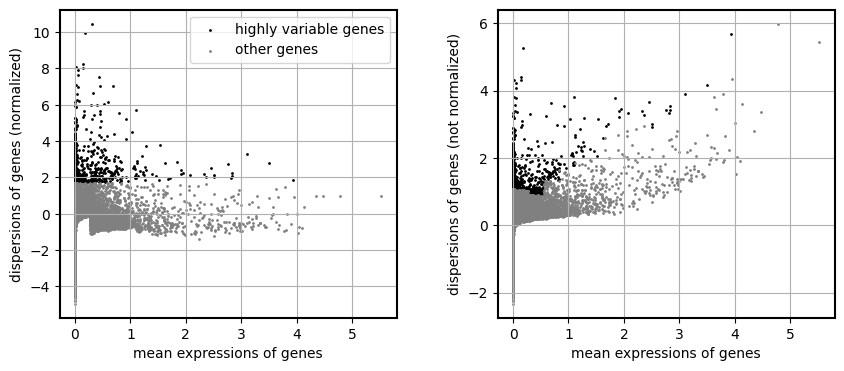

In [ ]:
#feature selection
sc.pp.highly_variable_genes(adata_mock, n_top_genes=1000)
sc.pl.highly_variable_genes(adata_mock)

Dimensionality Reduction

PCA

In [ ]:
def run_pca_umap(adata, n_pcs=40, n_neighbors=10):
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
    sc.tl.umap(adata)
    print("PCA and UMAP completed.")
    return adata

In [ ]:
#Dim Reduction
sc.tl.pca(adata_mock)

In [ ]:
#Dim Reduction
sc.tl.pca(adata_mock)

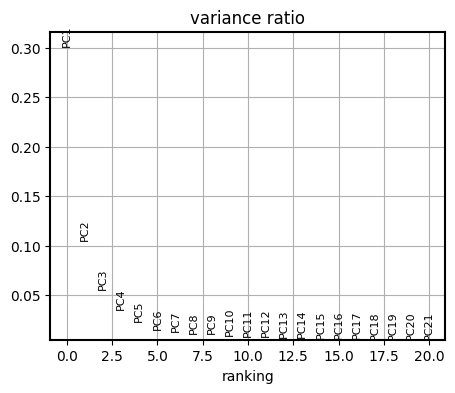

In [ ]:
from leidenalg.Optimiser import log
sc.tl.pca(adata_mock, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_mock, n_pcs=20,log=False)

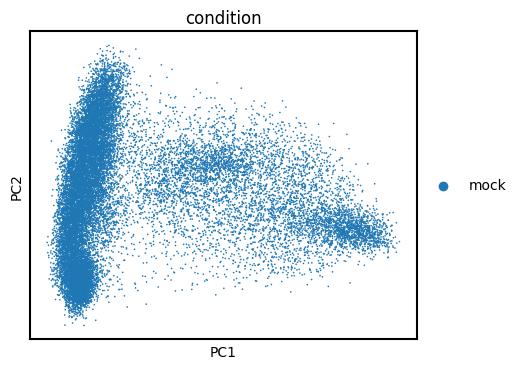

In [ ]:
adata_mock.obs['condition'] = 'mock'
sc.pl.pca(adata_mock, color="condition", cmap="coolwarm")

UMAP

In [ ]:
sc.pp.neighbors(adata_mock)
sc.tl.umap(adata_mock)

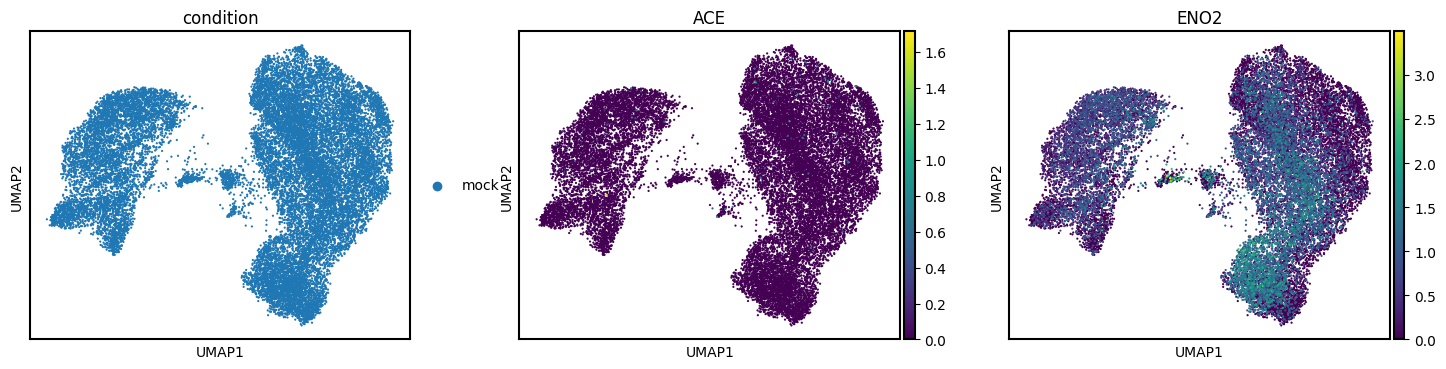

In [ ]:
sc.pl.umap(
    adata_mock,
    color=["condition", 'ACE', 'ENO2'],
    size=10,
)

In [ ]:
## Clustering by communities.

##Clustering by communities in single-cell RNA-seq is the process of grouping cells that show similar expression profiles — essentially, discovering putative cell types or states.

## Once PCA compresses your data into a manageable set of dimensions, clustering algorithms like Leiden operate on a graph-based representation of cell–cell relationships.

## Usually used for cell type detection

In [ ]:
def run_clustering(adata, resolution=0.02):
    sc.tl.leiden(adata, resolution=resolution)
    print(f"Leiden clustering done. Found {adata.obs['leiden'].nunique()} clusters.")
    return adata

In [ ]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata_mock, flavor="igraph", n_iterations=10, key_added="leiden_res_", resolution=0.25 )

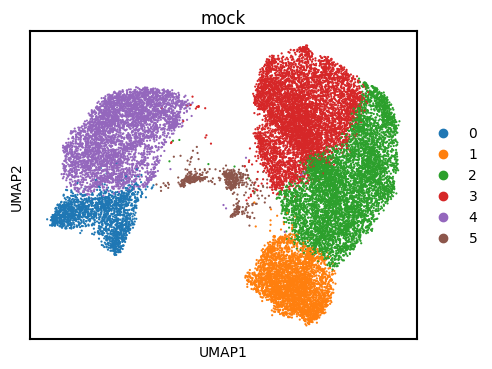

In [ ]:
sc.pl.umap(
    adata_mock,
    color=["leiden_res_"],
    size=10,
    title= 'mock'
)

Cell Annotation

Decoupler and Panglao DB

In [ ]:
# Import decoupler for automatic mapping
import decoupler as dc

In [ ]:
# Query Omnipath and get PanglaoDB
markers = dc.op.resource(name="PanglaoDB", organism="human")

In [ ]:
markers.shape

(8211, 13)

In [ ]:
markers.head()

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
,,,,,,,,,,,,,
0,A1CF,False,Hepatocytes,Endoderm,True,0.189189,0.004437,True,0.175000,0.000257,9606,Liver,0.002
1,A2APA5,False,Germ cells,Mesoderm,False,0.000000,0.000000,True,0.432927,0.000000,10090,Reproductive,0.004
2,A2M,True,Bergmann glia,Ectoderm,True,0.000000,0.062343,True,0.333333,0.001604,9606,Brain,0.012
3,A3FIN4,False,Mast cells,Mesoderm,False,0.000000,0.000000,True,0.184211,0.000708,10090,Immune system,0.001
4,A4GALT,True,Mast cells,Mesoderm,True,0.000000,0.014133,True,0.000000,0.003023,9606,Immune system,0.005


In [ ]:
markers['organ'].unique()

array(['Liver', 'Reproductive', 'Brain', 'Immune system', 'Zygote',
       'Kidney', 'Blood', 'Lungs', 'Bone', 'GI tract', nan, 'Vasculature',
       'Pancreas', 'Heart', 'Mammary gland', 'Olfactory system',
       'Connective tissue', 'Epithelium', 'Skeletal muscle', 'Skin',
       'Embryo', 'Smooth muscle', 'Eye', 'Adrenal glands', 'Thyroid',
       'Placenta', 'Thymus', 'Parathyroid glands', 'Oral cavity',
       'Urinary bladder'], dtype=object)

In [ ]:
markers = markers[markers["organ"].isin(['Lungs', 'Epithelium', 'Immune system', 'Smooth Muscles'])]

In [ ]:
markers.shape

(2099, 13)

In [ ]:
import decoupler as dc
import pandas as pd

# 1. Re-load markers from the resource to ensure it's in the initial state
markers = dc.op.resource(name="PanglaoDB", organism="human")

# 2. Filter by organ
if 'organ' in markers.columns:
    markers = markers[markers["organ"].isin(['Lungs', 'Epithelium', 'Smooth muscle'])]
else:
    print("Warning: 'organ' column not found for organ filtering. Skipping.")

# 3. Remove duplicated entries using 'cell_type' and 'genesymbol'
# Check if columns exist before trying to use them for duplicated check
if 'cell_type' in markers.columns and 'genesymbol' in markers.columns:
    markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]
else:
    print("Warning: 'cell_type' or 'genesymbol' column not found for duplicate removal. Skipping.")

# 4. Format because dc only accepts cell_type and genesymbol as 'source' and 'target'
# Check if columns exist before renaming
if 'cell_type' in markers.columns and 'genesymbol' in markers.columns:
    markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target"})
else:
    print("Warning: 'cell_type' or 'genesymbol' column not found for renaming. Skipping.")

# 5. Select only 'source' and 'target' if they exist
if 'source' in markers.columns and 'target' in markers.columns:
    markers = markers[["source", "target"]]
else:
    print("Warning: 'source' or 'target' columns not found after processing. Final markers might be empty or incomplete.")

markers.head()

,source,target
,,
18,Pulmonary alveolar type II cells,ABCA3
31,Pulmonary alveolar type II cells,ABCD3
53,Basal cells,ACADVL
73,Mesothelial cells,ACKR3
75,Smooth muscle cells,ACKR3


In [ ]:
adata_mock.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1', 'AC233755.2',
       'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C', 'scv2_orf1-10'],
      dtype='object', length=33539)

In [ ]:
import decoupler as dc
#mock
dc.mt.ulm(data=adata_mock, net=markers, tmin=3)

In [ ]:
#mock
score_mock = dc.pp.get_obsm(adata_mock, key="score_ulm")

In [ ]:
#Rank genes

#mock
adata_mock_gene_rank = dc.tl.rankby_group(score_mock, groupby="leiden_res_", reference="rest", method="t-test_overestim_var")
adata_mock_gene_rank = adata_mock_gene_rank[adata_mock_gene_rank["stat"] > 0]
adata_mock_gene_rank.head(5)

,group,reference,name,stat,meanchange,pval,padj
6,0,rest,Ciliated cells,27.042372,1.683879,1.217574e-146,2.783025e-146
14,0,rest,Airway epithelial cells,4.550644,0.145332,5.525228e-06,5.893576e-06
16,1,rest,Myoepithelial cells,95.595402,5.544998,0.000000e+00,0.000000e+00
17,1,rest,Basal cells,73.724988,4.784918,0.000000e+00,0.000000e+00
23,1,rest,Myofibroblasts,39.395814,0.838718,1.205816e-299,2.411633e-299


In [ ]:
#mock
top_cell_type_per_group_mock = adata_mock_gene_rank.groupby('group')['name'].apply(lambda x: x.head(1))
display(top_cell_type_per_group_mock.to_dict())

/tmp/ipython-input-1202130965.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_cell_type_per_group_mock = adata_mock_gene_rank.groupby('group')['name'].apply(lambda x: x.head(1))


{('0', 6): 'Ciliated cells',
 ('1', 16): 'Myoepithelial cells',
 ('2', 35): 'Mesothelial cells',
 ('3', 48): 'Airway goblet cells',
 ('4', 64): 'Ciliated cells',
 ('5', 87): 'Vascular smooth muscle cells'}

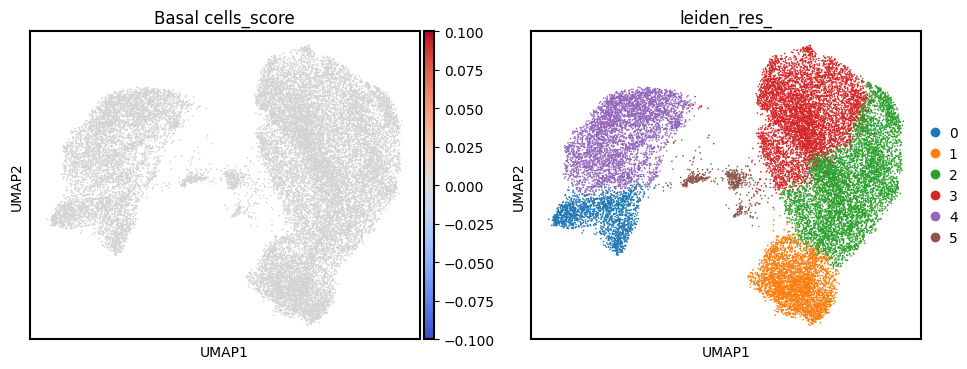

In [ ]:
# To plot the 'Basal cells' scores on the UMAP of adata_mock, we need to extract this score from score_mock and add it to adata_mock.obs.
# The 'leiden_res0_02' key is incorrect; it should be 'leiden_res_'.

# Check if 'Basal cells' is a column in score_mock.var_names before trying to add it.
if 'Basal cells' in score_mock.var_names:
    adata_mock.obs['Basal cells_score'] = score_mock[:, 'Basal cells'].X.flatten()
    sc.pl.umap(adata_mock, color=["Basal cells_score", "leiden_res_"], cmap="coolwarm")
else:
    print("Warning: 'Basal cells' score not found in score_mock. Plotting only leiden_res_.")
    sc.pl.umap(adata_mock, color=["leiden_res_"], cmap="coolwarm")

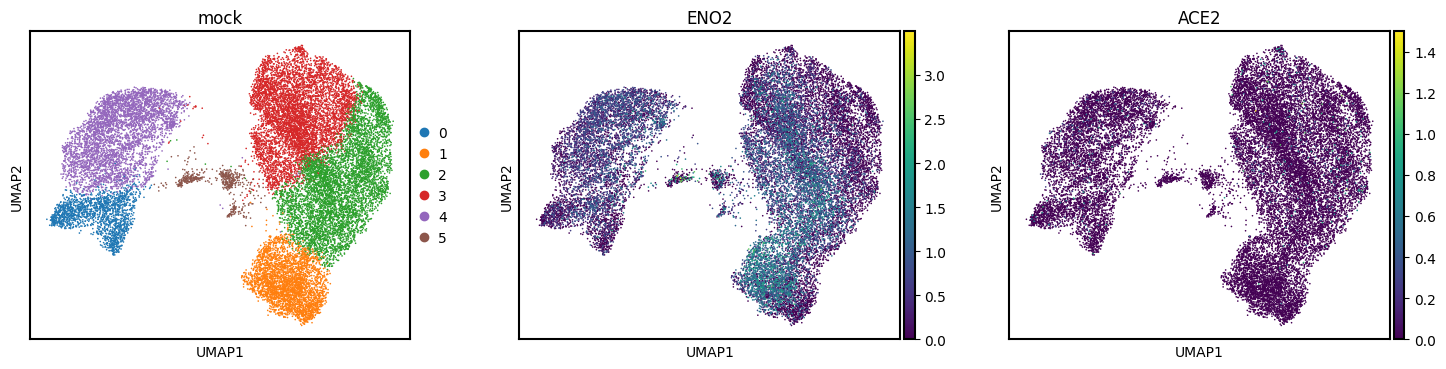

In [ ]:
sc.pl.umap(
    adata_mock,
    color=[ "leiden_res_", 'ENO2', 'ACE2'],
    ncols=8,
    title= 'mock'
)

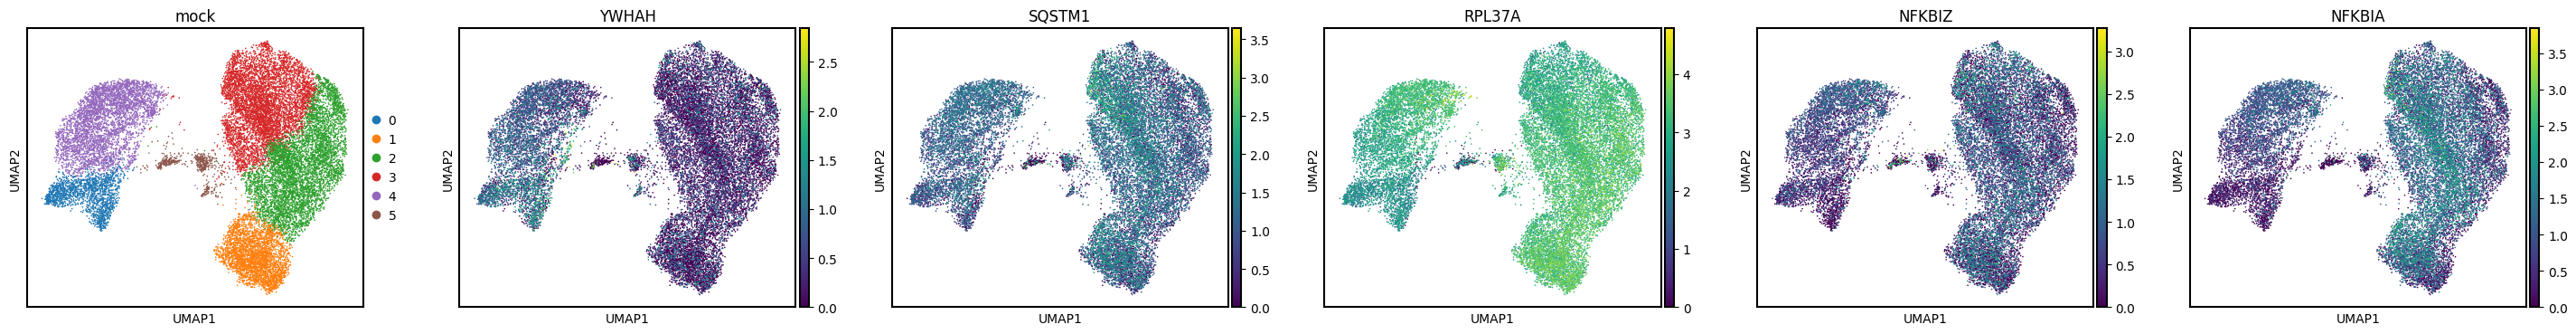

In [ ]:
sc.pl.umap(
    adata_mock,
    color=[ "leiden_res_", 'YWHAH', 'SQSTM1', 'RPL37A', 'NFKBIZ', 'NFKBIA'],
    ncols=8,
    title= 'mock'
)

In [ ]:
#mock
dict_ann_mock_raw = adata_mock_gene_rank[adata_mock_gene_rank["stat"] > 0].groupby("group").head().set_index("group")["name"].to_dict()
dict_ann_mock = {k: f"{v} ({k})" for k, v in dict_ann_mock_raw.items()}
display(dict_ann_mock)

/tmp/ipython-input-480143536.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dict_ann_mock_raw = adata_mock_gene_rank[adata_mock_gene_rank["stat"] > 0].groupby("group").head().set_index("group")["name"].to_dict()


{'0': 'Airway epithelial cells (0)',
 '1': 'Mesothelial cells (1)',
 '2': 'Myoepithelial cells (2)',
 '3': 'Epithelial cells (3)',
 '4': 'Pulmonary alveolar type II cells (4)',
 '5': 'Ionocytes (5)'}

In [ ]:
#mock
adata_mock.obs["leiden_res_"] = adata_mock.obs["leiden_res_"][:].astype('category').cat.rename_categories(dict_ann_mock)

In [ ]:
print("Performing differential expression analysis for mock_adata...")
sc.tl.rank_genes_groups(adata_mock, groupby='leiden_res_', method='wilcoxon', rankby_abs=True, key_added='rank_genes_groups_mock')

Performing differential expression analysis for mock_adata...


In [ ]:
data_combined = ad.concat([adata_mock])

# Create a combined 'condition_cell_type' column for dot plot grouping
data_combined.obs['condition_cell_type'] = data_combined.obs['condition'].astype(str) + '_' + data_combined.obs['leiden_res_'].astype(str)

print("Combined AnnData object created and 'condition_cell_type' column added.")
print(data_combined.obs['condition_cell_type'].value_counts().head())

Combined AnnData object created and 'condition_cell_type' column added.
condition_cell_type
mock_Epithelial cells (3)                    5968
mock_Myoepithelial cells (2)                 5946
mock_Pulmonary alveolar type II cells (4)    4219
mock_Mesothelial cells (1)                   3337
mock_Airway epithelial cells (0)             1812
Name: count, dtype: int64


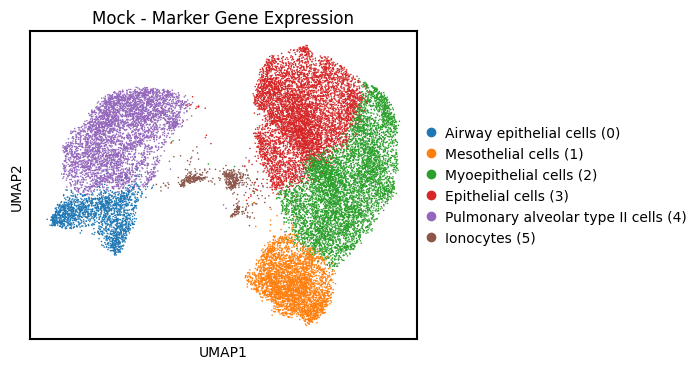

In [ ]:
#Visualisation of cell annotation
# Leiden clustering identifies transcriptionally similar cell groups.
# This helps distinguish infected vs. bystander cell populations across infection stages.
#mock
sc.pl.umap(
    adata_mock,
    color=["leiden_res_"],
    ncols=3,
    title='Mock - Marker Gene Expression',
    size=5
)

In [ ]:
data_combined.obs['condition'].value_counts()

,count
condition,
mock,21825


/tmp/ipython-input-3146228492.py:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


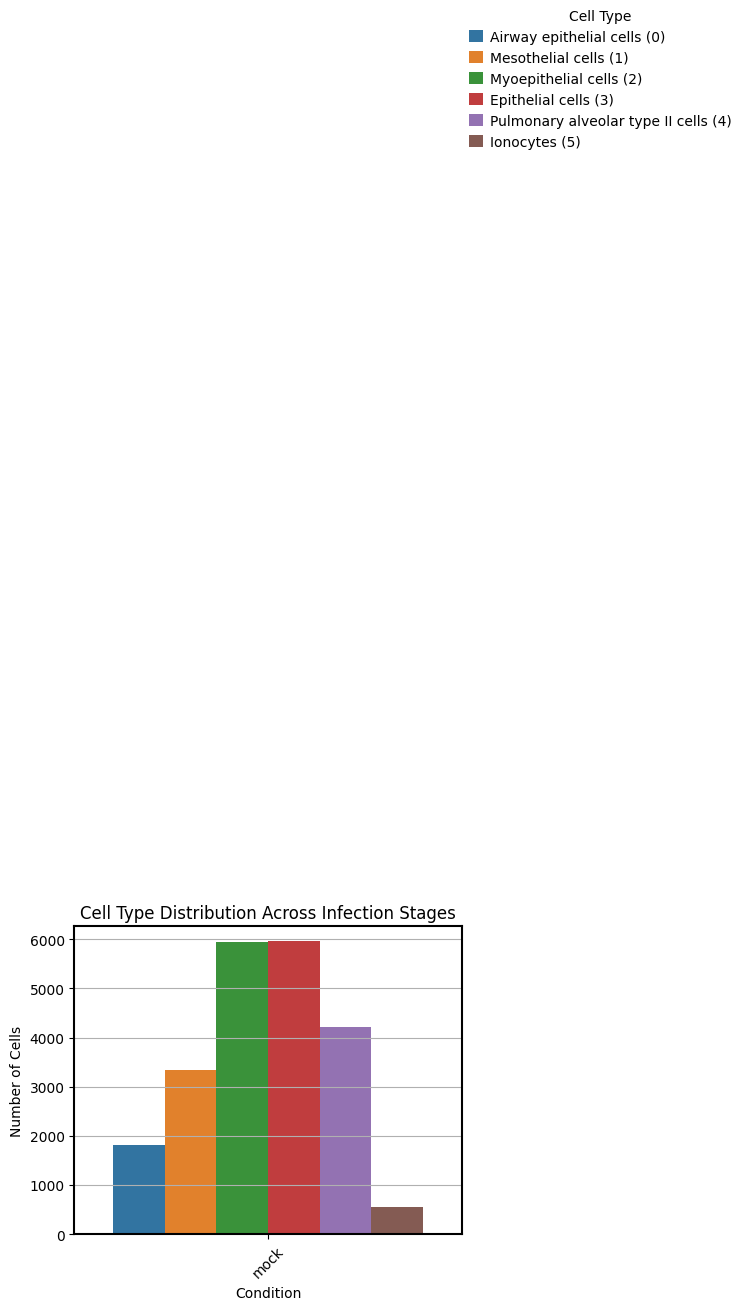

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cell type frequency per condition
# Use 'leiden_res_' column which contains the annotated cell types
cell_counts = data_combined.obs.groupby(['condition', 'leiden_res_'], observed=True).size().reset_index(name='count')

sns.barplot(data=cell_counts, x='condition', y='count', hue='leiden_res_')
plt.title("Cell Type Distribution Across Infection Stages")
plt.ylabel("Number of Cells")
plt.xlabel("Condition")
plt.xticks(rotation=45)
plt.legend(title='Cell Type', bbox_to_anchor=(1,4), loc='upper left')
plt.tight_layout()
plt.show()

Trajectory Inference It is an attempt to understand how cells transition from one type to another (like stem → mature)?

In [80]:
#Trajectory analysis
sc.tl.draw_graph(adata_mock)

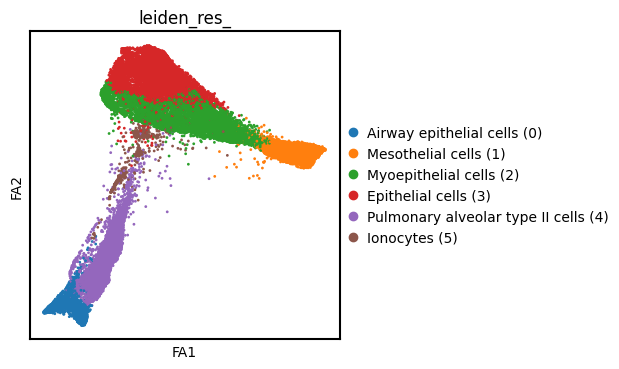

In [82]:
# mock
plt.rcParams["figure.figsize"] = (4,4)
sc.pl.draw_graph(adata_mock, color='leiden_res_', size = 16)

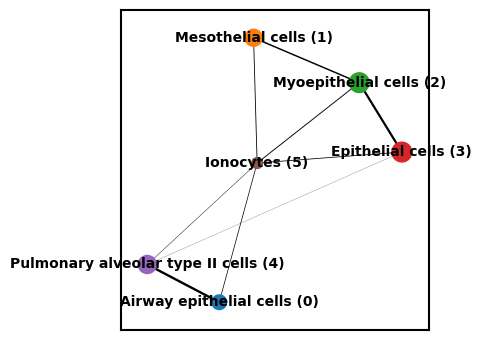

In [84]:
#PAGA mock

sc.tl.paga(adata_mock, groups='leiden_res_')

sc.pl.paga(adata_mock, color=['leiden_res_'])

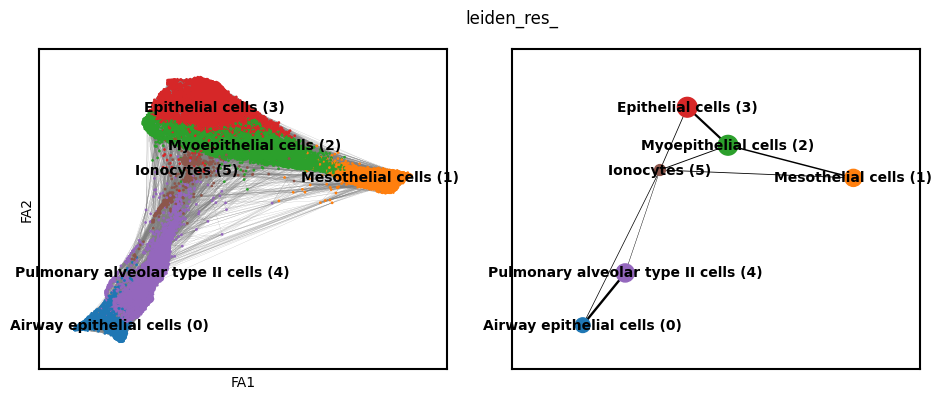

[<Axes: xlabel='FA1', ylabel='FA2'>, <Axes: >]

In [85]:
#mock
plt.rcParams["figure.figsize"] = (5,4)
sc.pl.paga_compare(adata_mock, threshold=0.03, frameon=True, edges=True, size = 16)

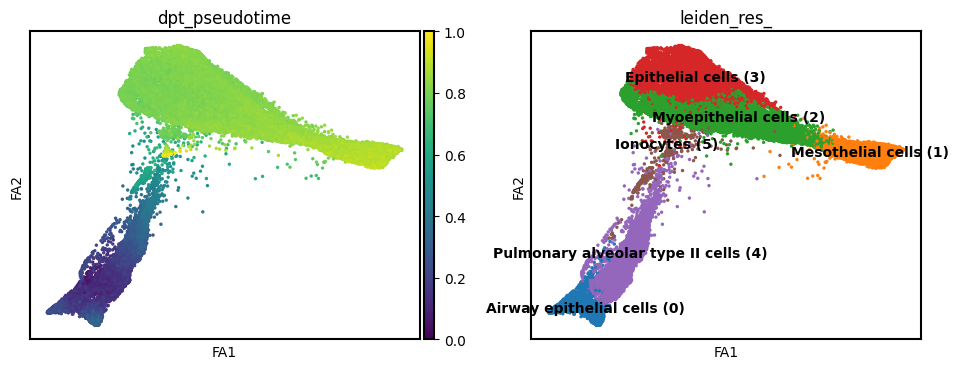

In [88]:
# Calculate diffusion pseudotime (DPT)

# mock
# As an example, let's select a cell from the first cluster (cluster '0') as the root.
# You might need to adjust this based on your biological knowledge.
root_cluster_mock = 'Airway epithelial cells (0)' # Corrected: using the annotated name for original cluster 0
if root_cluster_mock in adata_mock.obs['leiden_res_'].cat.categories:
    root_cell_idx_mock = adata_mock.obs['leiden_res_'] == root_cluster_mock
    if np.any(root_cell_idx_mock):
        adata_mock.uns['iroot'] = np.flatnonzero(root_cell_idx_mock)[0] # Set iroot
        sc.tl.dpt(adata_mock) # Call dpt without the 'root' argument
    else:
        print(f"Warning: No cells found in cluster {root_cluster_mock} for mock_adata. Skipping DPT calculation.")
else:
    print(f"Warning: Cluster {root_cluster_mock} not found in mock_adata. Skipping DPT calculation.")

    # Now plot with dpt_pseudotime
sc.pl.draw_graph(adata_mock, color=['dpt_pseudotime', 'leiden_res_'], legend_loc='on data', size = 24)

In [89]:
import numpy as np
from scipy.stats import wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt

# Compare ACE2 expression across conditions
ace2_means = [adata_mock[:, 'ACE2'].X.mean()]

# Bootstrapped confidence intervals
boot_samples = 1000
ci_low, ci_high = np.percentile(
    [np.mean(np.random.choice(ace2_means, size=len(ace2_means), replace=True))
     for _ in range(boot_samples)],
    [2.5, 97.5]
)

print(f"95% CI for ACE2 mean expression: [{ci_low:.4f}, {ci_high:.4f}]")

95% CI for ACE2 mean expression: [0.0124, 0.0124]


<Axes: >

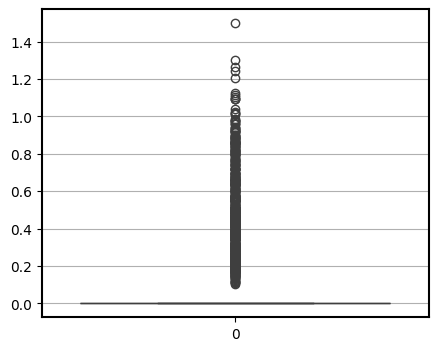

In [91]:
sns.boxplot(data=[adata_mock[:, 'ACE2'].X.toarray().flatten()])

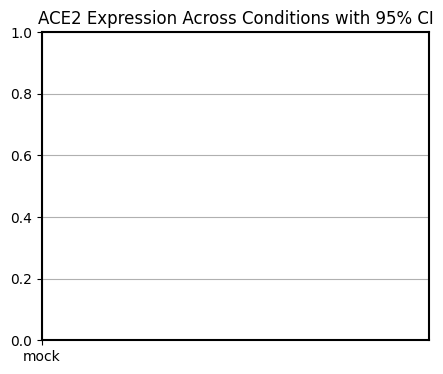

In [93]:
plt.xticks([0], ['mock'])
plt.title("ACE2 Expression Across Conditions with 95% CI")
plt.show()